# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
# import torchvision as tv
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader
import torchvision.transforms as tt

from tqdm.notebook import tqdm
# from tqdm import tqdm
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.utils import make_grid
from torch.utils.data import random_split

In [2]:
data_dir = './data/'

# Load the Data

In [3]:
# #If the data is not downloaded
# CIFAR100(data_dir, download=True)

In [4]:
BATCH_SIZE = 128

In [5]:
train_data = CIFAR100(data_dir, train=True , transform=tt.PILToTensor())
test_data  = CIFAR100(data_dir, train=False, transform=tt.PILToTensor())

In [6]:
CLASSES = train_data.classes
print(CLASSES)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [7]:
num_classes= len(CLASSES)

In [8]:
def show_image(data, classes, ax):
    img, label = data
    ax.imshow(img.permute(1,2,0))
    ax.set_title(f"{classes[label]}")
    ax.set_xticks([])
    ax.set_yticks([])

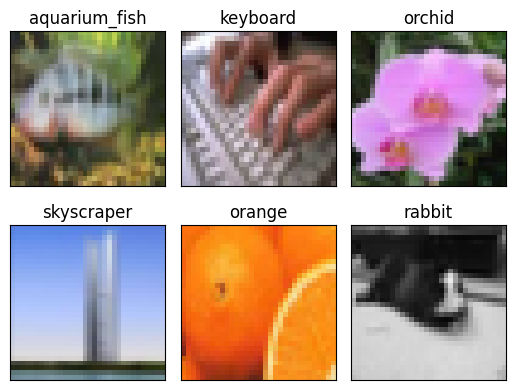

In [9]:
random_train_indices = np.random.choice(range(len(train_data)),
                                        size=6,
                                        replace=False)

fig, axs = plt.subplots(2,3)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

for i, ax in zip(random_train_indices, axs.flat):
    show_image(train_data[i], CLASSES, ax)

In [10]:
def show_batch(dataloader):
    for images, _ in dataloader:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

In [11]:
torch.manual_seed(42)
val_size = int(0.1 * len(train_data))
train_set, valid_set = random_split(train_data, [len(train_data)-val_size, val_size])

train_loader = DataLoader(train_set, BATCH_SIZE  , num_workers=4, pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_set, 2*BATCH_SIZE, num_workers=4, pin_memory=True)

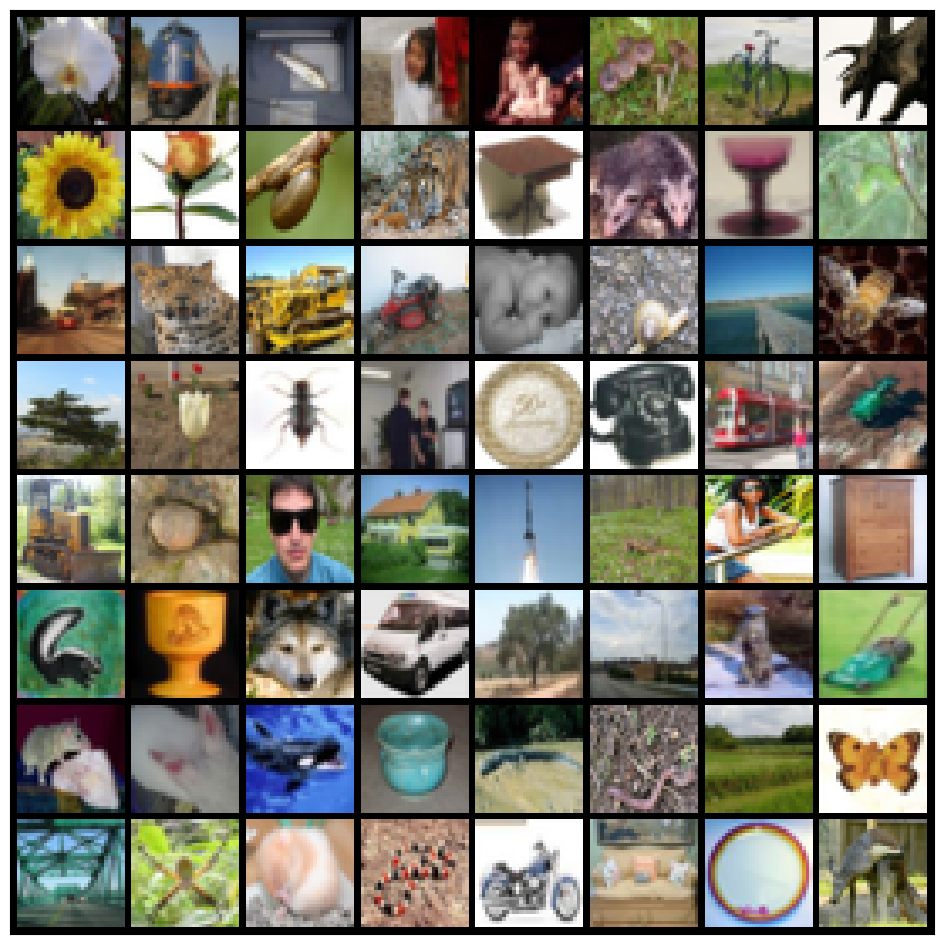

In [12]:
show_batch(train_loader)

# Use GPU

In [13]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [14]:
device = get_default_device()
device

device(type='cuda')

In [15]:
train_dl = DeviceDataLoader(train_loader, device)
valid_dl = DeviceDataLoader(valid_loader, device)

# Model

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out  = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out  = self(images)                   # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc  = accuracy(out, labels)          # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss   = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs   = [x['val_acc'] for x in outputs]
        epoch_acc    = torch.stack(batch_accs).mean()     # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '',
            result['train_loss'], result['val_loss'], result['val_acc']))


In [17]:
Main_Transforms = nn.Sequential(
    tt.RandomHorizontalFlip(),
    tt.RandomAutocontrast(1),
    tt.RandomRotation(10),
    ResNet34_Weights.IMAGENET1K_V1.transforms(),
)

In [18]:
class CIFAR100Classifier(ImageClassificationBase):
    def __init__(self, num_classes, transform, pretrained=True):
        super().__init__()
        self.ResNet = resnet34(weights=ResNet34_Weights) if pretrained else resnet34()
        self.network =  torch.nn.Sequential(
                            transform,
                            self.ResNet,
                            torch.nn.Linear(self.ResNet.fc.out_features, num_classes)
                        )
    def forward(self, xb):
        return self.network(xb)

# Training

## Fitting Functions

In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [20]:
model = CIFAR100Classifier(num_classes, Main_Transforms, pretrained=True)
to_device(model, device)

C:\Users\Rebel1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CIFAR100Classifier(
  (ResNet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

## Start the Training

In [21]:
history = [evaluate(model, valid_dl)]
history

C:\Users\Rebel1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[{'val_loss': 5.501646518707275, 'val_acc': 0.005078124813735485}]

In [22]:
epochs = 15
max_lr = 0.01
grad_clip = 0.15
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [23]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl,
                            grad_clip=grad_clip,
                            weight_decay=weight_decay,
                            opt_func=opt_func)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

# See the Results

In [ ]:
epoch_list = list(range(epochs+1))
val_accs = [i['val_acc' ] for i in history]
val_loss = [i['val_loss'] for i in history]

plt.plot(epoch_list, val_accs,'x-', label="Validation Accuracy",)

plt.xlim(0,epochs+1)
plt.ylim(0,1)
plt.legend()
plt.xlabel('Epoch')
plt.grid(which='major',ls='-')
plt.grid(which='minor',ls='--')

In [ ]:
epoch_list = list(range(epochs))
train_loss = [ i['train_loss'] for i in history[1:] ]
val_loss   = [ i['val_loss'  ] for i in history[1:] ]

plt.plot(epoch_list, train_loss,'x-', label="Training Loss"  )
plt.plot(epoch_list, val_loss  ,'x-', label="Validation Loss")

plt.xlim(0,epochs)
plt.ylim(bottom=0)#,1)
plt.legend()
plt.xlabel('Epoch')
plt.grid(which='major',ls='-')
plt.grid(which='minor',ls='--')

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_data.classes[preds[0].item()]

In [ ]:
img, label = test_data[16]
plt.title(f"True: {test_data.classes[label]}\nPredicted: {predict_image(img, model)}")
plt.imshow(img.permute(1, 2, 0))

# Rough

In [2]:
from sklearn.metrics import accuracy_score

In [6]:
# accuracy_score(y_true, y_pred)

0.5